Copyright 2018 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

 [https://www.apache.org/licenses/LICENSE-2.0](https://www.apache.org/licenses/LICENSE-2.0)

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.


번역: [webofthink](webofthink@snu.ac.kr)

# 1차원 회귀 문제를 위한 조건부 뉴럴 프로세스 (CNP)

[Conditional Neural Processes](https://arxiv.org/pdf/1807.01613.pdf) (CNPs)는 
[Generative Query Networks](https://deepmind.com/blog/neural-scene-representation-and-rendering/)
(GQN) 의 일환으로 씬 랜더링(scene randering)을 넘어서 자체의 훈련 방식을 확장한 문제들(예, 회귀/분류 문제)에 적용하기 위해 등장했습니다. 

단 하나의 함수를 근사(approximate)하는 일반적인 뉴럴넷과 다르게 CNP는 함수들의 분포를 근사하기 위해서 학습합니다. 
그 결과, 평가 시에 CNP는 적은 수의 관찰 결과들을 제공했을 때 학습된 분포에서 어떤 함수나 근사할 수 있게 됩니다.
더불어, CNP는 데이터셋에서부터 이런 예측이 가지는 불확실성을 평가할 수 있도록 학습하고 관찰 수가 증가하게 되면 이 불확실성은 줄어들고 예측력이 향상됩니다.  

여기서는 CNP가 어떻게 다른지를 설명하고 결과 모델을 랜덤 함수들로 생성한 데이터셋으로 학습한 1차원 회귀 문제에 적용해 봅니다.

CNP에 대한 궁금한 점이 있거나 이 문서에 대한 피드백이 있다면 garnelo@google.com 으로 연락주시기 바랍니다..

## CNP 구현

먼저 이 코드를 수행하기 위해 필요한 패키지들(numpy, tensorflow, mathplotlib 등)을 임포트합니다.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
import collections

## 학습 데이터

CNP의 가장 핵심 요소는 테스트 시점에서의 유연성입니다. 이 알고리즘은 모든 범위의 함수들을 모델링할 수 있고 관찰 데이터 수가 증가하면 알고리즘의 예측 범위를 줄여 갑니다.이 데이터셋으로 CNP 학습 방식의 결과로써 이런 행태가 나타날 것입니다.

![](https://bit.ly/2O2Lq8c)

보편적인 기계학습에서 그렇듯 한 함수에서 얻은 관찰 값들을 사용해서 학습하기 보다는 내재된 특성을 공유하는 서로 다른 함수들을 구성해서 만든 데이터를 사용할 예정입니다. 위의 그림은 이를 도식화한 것입니다.
왼쪽 그림은 전통적인 학습 방식에 관련된 그림인데, 회색 선은 한 개의 내재된 정답 함수(a single underlying ground truth function)을 나타내고, 여러 다른 색으로 표시한 점들은 매번 학습할 때마다 이 함수에서 나온 적은 수의 샘플들을 표현한 것입니다.  


오른쪽 그림은 뉴럴넷을 학습할 때 사용할 수 있는 데이터셋의 예시를 보여줍니다.
이 데이터셋에는 함수 하나 대신에 모델링하기를 원하는 함수 클래스에 속한 많은 수의 함수들로 구성되어 있습니다.
매 반복(iteration)마다, 데이터셋에서 임의로 하나의 함수를 선택하고, 학습하기 위해 그 함수에서 관찰 값 몇 개를 뽑습니다. 
그리고 다음 반복 시점에는 이 함수를 되돌려 놓고 데이터셋에서 새로운 함수 하나를 뽑은 후 학습 데이터를 선택하기 위한 새로운 함수로 사용합니다.
이런 데이터셋의 형태는 모델이 특정 함수에 과적합(overfit)되지 않도록 막고, 그 대신 함수들의 분포를 학습하게 됩니다. 
또한  이런 계층적인 데이터셋 아이디어가 현재의 메타러닝 방법들의 핵심에 맞닿아 있습니다.

다음과 같은 데이터셋들이 예시가 될 수 있습니다:

* 세계 여러 도시들의 시간에 따른 온도 변화를 표현하는 함수들
* 다양한 인간의 걸음 걸이에 대해 모션 캡쳐로 생성한 데이터셋  
* 이 예시처럼 어떤 한 커널을 이용해 가우시안 프로세스(GP)로 생성한 여러 함수들

이 예시에서는 GP를 선택해서 데이터를 만들었는데 이 방식은 어떤 내재적인 특성들(여기에서는 커널 함수)을 공유하는 부드러운 곡선들을 샘플링하기 쉬운 방식으로 구성되어 있기 때문입니다. 
덧붙여 이 예제를 위한 데이터 생성 이외에 뉴럴넷으로 구현되는 뉴럴 프로세스는 커널 또는 GP를 이용하지 않습니다. 

## 데이터 생성기

다음 장에는 함수들의 데이터셋을 생성하기 위해 GP로 학습 및 평가 데이터셋을 생성하기 위한 코드를 제공합니다. 
다음에 설명하겠지만, CNP는 매 반복마다 두 가지의 부분집합을 사용하는데 하나는 문맥(context)을 제공하기 위함이고 남은 하나는 목표(target)를 위함입니다.
우리는 새로운 추가적인 데이터 값들로써 문맥 정보 값을 목표 값과 함께 포함시키는 것이 실질적으로 훈련에 도움이 되는 것을 발견했습니다. 
이 데이터 생성기는 이렇게 생성 데이터를 두 집단으로 나누고 올바른 포멧으로 제공합니다.

In [2]:
# The CNP takes as input a `CNPRegressionDescription` namedtuple with fields:
#   `query`: a tuple containing ((context_x, context_y), target_x)
#   `target_y`: a tesor containing the ground truth for the targets to be
#     predicted
#   `num_total_points`: A vector containing a scalar that describes the total
#     number of datapoints used (context + target)
#   `num_context_points`: A vector containing a scalar that describes the number
#     of datapoints used as context
# The GPCurvesReader returns the newly sampled data in this format at each
# iteration

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription",
    ("query", "target_y", "num_total_points", "num_context_points"))


class GPCurvesReader(object):
  """Generates curves using a Gaussian Process (GP).

  Supports vector inputs (x) and vector outputs (y). Kernel is
  mean-squared exponential, using the x-value l2 coordinate distance scaled by
  some factor chosen randomly in a range. Outputs are independent gaussian
  processes.
  """

  def __init__(self,
                       batch_size,
                       max_num_context,
                       x_size=1,
                       y_size=1,
                       l1_scale=0.4,
                       sigma_scale=1.0,
                       testing=False):
    """Creates a regression dataset of functions sampled from a GP.

    Args:
      batch_size: An integer.
      max_num_context: The max number of observations in the context.
      x_size: Integer >= 1 for length of "x values" vector.
      y_size: Integer >= 1 for length of "y values" vector.
      l1_scale: Float; typical scale for kernel distance function.
      sigma_scale: Float; typical scale for variance.
      testing: Boolean that indicates whether we are testing. If so there are
          more targets for visualization.
    """
    self._batch_size = batch_size
    self._max_num_context = max_num_context
    self._x_size = x_size
    self._y_size = y_size
    self._l1_scale = l1_scale
    self._sigma_scale = sigma_scale
    self._testing = testing

  def _gaussian_kernel(self, xdata, l1, sigma_f, sigma_noise=2e-2):
    """Applies the Gaussian kernel to generate curve data.

    Args:
      xdata: Tensor with shape `[batch_size, num_total_points, x_size]` with
          the values of the x-axis data.
      l1: Tensor with shape `[batch_size, y_size, x_size]`, the scale
          parameter of the Gaussian kernel.
      sigma_f: Float tensor with shape `[batch_size, y_size]`; the magnitude
          of the std.
      sigma_noise: Float, std of the noise that we add for stability.

    Returns:
      The kernel, a float tensor with shape
      `[batch_size, y_size, num_total_points, num_total_points]`.
    """
    num_total_points = tf.shape(xdata)[1]

    # Expand and take the difference
    xdata1 = tf.expand_dims(xdata, axis=1)  # [B, 1, num_total_points, x_size]
    xdata2 = tf.expand_dims(xdata, axis=2)  # [B, num_total_points, 1, x_size]
    diff = xdata1 - xdata2  # [B, num_total_points, num_total_points, x_size]

    # [B, y_size, num_total_points, num_total_points, x_size]
    norm = tf.square(diff[:, None, :, :, :] / l1[:, :, None, None, :])

    norm = tf.reduce_sum(
        norm, -1)  # [B, data_size, num_total_points, num_total_points]

    # [B, y_size, num_total_points, num_total_points]
    kernel = tf.square(sigma_f)[:, :, None, None] * tf.exp(-0.5 * norm)

    # Add some noise to the diagonal to make the cholesky work.
    kernel += (sigma_noise**2) * tf.eye(num_total_points)

    return kernel

  def generate_curves(self):
    """Builds the op delivering the data.

    Generated functions are `float32` with x values between -2 and 2.
    
    Returns:
      A `CNPRegressionDescription` namedtuple.
    """
    num_context = tf.random_uniform(
        shape=[], minval=3, maxval=self._max_num_context, dtype=tf.int32)

    # If we are testing we want to have more targets and have them evenly
    # distributed in order to plot the function.
    if self._testing:
      num_target = 400
      num_total_points = num_target
      #x_values = tf.tile(
       #   tf.expand_dims(tf.range(-2., 2., 1. / 100, dtype=tf.float32), axis=0),
        #  [self._batch_size, self._x_size])
      #x_values = tf.expand_dims(x_values, axis=-1)

    # During training the number of target points and their x-positions are
    # selected at random
    else:
      num_target = tf.random_uniform(
          shape=(), minval=2, maxval=self._max_num_context, dtype=tf.int32)
      num_total_points = num_context + num_target
    x_values = tf.random_uniform(
          [self._batch_size, num_total_points, self._x_size], -2, 2)

    # Set kernel parameters
    l1 = ( tf.ones(shape=[self._batch_size, self._y_size, self._x_size]) * self._l1_scale)
    sigma_f = tf.ones(shape=[self._batch_size, self._y_size]) * self._sigma_scale

    # Pass the x_values through the Gaussian kernel
    # [batch_size, y_size, num_total_points, num_total_points]
    kernel = self._gaussian_kernel(x_values, l1, sigma_f)

    # Calculate Cholesky, using double precision for better stability:
    cholesky = tf.cast(tf.cholesky(tf.cast(kernel, tf.float64)), tf.float32)

    # Sample a curve
    # [batch_size, y_size, num_total_points, 1]
    y_values = tf.matmul(
        cholesky,
        tf.random_normal([self._batch_size, self._y_size, num_total_points, 1]))

    # [batch_size, num_total_points, y_size]
    y_values = tf.transpose(tf.squeeze(y_values, 3), [0, 2, 1])

    if self._testing:
      # Select the targets
      target_x = x_values
      target_y = y_values

      # Select the observations
      idx = tf.random_shuffle(tf.range(num_target))
      context_x = tf.gather(x_values, idx[:num_context], axis=1)
      context_y = tf.gather(y_values, idx[:num_context], axis=1)

    else:
      # Select the targets which will consist of the context points as well as
      # some new target points
      target_x = x_values[:, :num_target + num_context, :]
      target_y = y_values[:, :num_target + num_context, :]

      # Select the observations
      context_x = x_values[:, :num_context, :]
      context_y = y_values[:, :num_context, :]

    query = ((context_x, context_y), target_x)

    return CNPRegressionDescription(
        query=query,
        target_y=target_y,
        num_total_points=tf.shape(target_x)[1],
        num_context_points=num_context)

## 조건부 뉴럴 프로세스

CNP에서의 전방 학습 경로(forward pass)를 다음과 같이 표현할 수 있습니다:

<img src="https://bit.ly/2OFb6ZK" alt="drawing" width="400"/>

위의 도식에서 표현된 것처럼 CNP는 문맥 데이터 값인 (x, y)<sub>i</sub> 쌍을 인코더(encoder) 를 통과시키고 통합기(aggregator)를 이용해 결합시킨 후, 독립적인 표현 값(representations) r<sub>i</sub>를 얻습니다. 
결과적으로 표현된 r에는 목표 값 x<sub>T</sub> 의 위치가 섞여서 목표 위치에서 현재 예측치에 대한 불확실성에 대한 측정치로써 y의 평균 예측 값을 함께 반환하는 디코더(decoder) 를 지납니다. 


따라서 CNP를 구현하는 것은 크게 세 가지 구성요소를 개발하는 것입니다:   

*   인코더
*   통합기
*   디코더

이 세 부분에 대한 상세한 설명은 아래의 코드와 함께 있습니다.  

## 인코더


모든 맥락 데이터들 사이에 인코더 e 가 공유되어 있고 이 인코더는 작은 층 수를 지닌 다층 퍼셉트론(MLP)으로 구성되어 있습니다.
이 예제에서는 4층으로도 충분하지만, 코드에서는 나중을 위해 `encoder_output_sizes` 변수를 통해 그래프를 만드는 시점에서 계층의 수를 바꿀 수도 있습니다.
각각의 문맥 쌍 (x, y)<sub>i</sub> 은 인코딩 이후 개개의 표현 값 r<sub>i</sub>의 결과로 나타납니다. 
이 표현 값들을 통합기 a를 이용해 모든 문맥 값들을 아울러 하나의 표현 값 r으로 결합됩니다.  


여기에서는 통합기 a 를 인코더에 포함시켜서 구현했는데, 모든 데이터들의 평균을 취하는 것만 고려했기 때문입니다. 
통합기가 생성한 표현 값 r에는 모든 문맥 데이터 값들에 의해 제공되어진 숨겨진 익명함수 f 에 관한 정보를 가지고 있습니다. 

In [3]:
class DeterministicEncoder(object):
  """The Encoder."""

  def __init__(self, output_sizes):
    """CNP encoder.

    Args:
      output_sizes: An iterable containing the output sizes of the encoding MLP.
    """
    self._output_sizes = output_sizes

  def __call__(self, context_x, context_y, num_context_points):
    """Encodes the inputs into one representation.

    Args:
      context_x: Tensor of size bs x observations x m_ch. For this 1D regression
          task this corresponds to the x-values.
      context_y: Tensor of size bs x observations x d_ch. For this 1D regression
          task this corresponds to the y-values.
      num_context_points: A tensor containing a single scalar that indicates the
          number of context_points provided in this iteration.

    Returns:
      representation: The encoded representation averaged over all context 
          points.
    """

    # Concatenate x and y along the filter axes
    encoder_input = tf.concat([context_x, context_y], axis=-1)

    # Get the shapes of the input and reshape to parallelise across observations
    batch_size, _, filter_size = encoder_input.shape.as_list()
    hidden = tf.reshape(encoder_input, (batch_size * num_context_points, -1))
    hidden.set_shape((None, filter_size))

    # Pass through MLP
    with tf.variable_scope("encoder", reuse=tf.AUTO_REUSE):
      for i, size in enumerate(self._output_sizes[:-1]):
        hidden = tf.nn.relu(
            tf.layers.dense(hidden, size, name="Encoder_layer_{}".format(i)))

      # Last layer without a ReLu
      hidden = tf.layers.dense(
          hidden, self._output_sizes[-1], name="Encoder_layer_{}".format(i + 1))

    # Bring back into original shape
    hidden = tf.reshape(hidden, (batch_size, num_context_points, size))

    # Aggregator: take the mean over all points
    representation = tf.reduce_mean(hidden, axis=1)

    return representation

## 디코더

학습을 통해 표현 값 r을 얻은 후, 각각의 목표 값 x<sub>t</sub> 를 합쳐서 디코더 d 를 통해 전달합니다.
인코더 e 처럼 모든 목표 데이터 값들 사이에 디코더 d가 공유되어 있고 이 디코더는 `decoder_output_sizes` 변수로 계층 수가 결정되는 작은 MLP로 구성되어 있습니다.
디코더는 모든 목표 값들 x<sub>t</sub>에 대한 평균 &mu;<sub>t</sub> 과 분산 &sigma;<sub>t</sub>을 출력합니다.
예측된 평균 &mu;<sub>t</sub>과 분산 &sigma;<sub>t</sub>으로 결정되는 가우시안 (Gaussian)에서의 정답 값 y<sub>t</sub>의 로그 우도 (log likelihood)를 사용해 CNP를 학습합니다. 
여기 구현된 버전은 붕괴 현상(collapsing)를 막기 위해 분산 &sigma;<sub>t</sub> 를 0.1에서 잘라 버립니다. 

In [4]:
class DeterministicDecoder(object):
  """The Decoder."""

  def __init__(self, output_sizes):
    """CNP decoder.

    Args:
      output_sizes: An iterable containing the output sizes of the decoder MLP 
          as defined in `basic.Linear`.
    """
    self._output_sizes = output_sizes

  def __call__(self, representation, target_x, num_total_points):
    """Decodes the individual targets.

    Args:
      representation: The encoded representation of the context
      target_x: The x locations for the target query
      num_total_points: The number of target points.

    Returns:
      dist: A multivariate Gaussian over the target points.
      mu: The mean of the multivariate Gaussian.
      sigma: The standard deviation of the multivariate Gaussian.
    """

    # Concatenate the representation and the target_x
    representation = tf.tile(
        tf.expand_dims(representation, axis=1), [1, num_total_points, 1])
    input = tf.concat([representation, target_x], axis=-1)

    # Get the shapes of the input and reshape to parallelise across observations
    batch_size, _, filter_size = input.shape.as_list()
    hidden = tf.reshape(input, (batch_size * num_total_points, -1))
    hidden.set_shape((None, filter_size))

    # Pass through MLP
    with tf.variable_scope("decoder", reuse=tf.AUTO_REUSE):
      for i, size in enumerate(self._output_sizes[:-1]):
        hidden = tf.nn.relu(
            tf.layers.dense(hidden, size, name="Decoder_layer_{}".format(i)))

      # Last layer without a ReLu
      hidden = tf.layers.dense(
          hidden, self._output_sizes[-1], name="Decoder_layer_{}".format(i + 1))

    # Bring back into original shape
    hidden = tf.reshape(hidden, (batch_size, num_total_points, -1))

    # Get the mean an the variance
    mu, log_sigma = tf.split(hidden, 2, axis=-1)

    # Bound the variance
    sigma = 0.1 + 0.9 * tf.nn.softplus(log_sigma)

    # Get the distribution
    dist = tfp.distributions.MultivariateNormalDiag(
        loc=mu, scale_diag=sigma)

    return dist, mu, sigma

## 모델

이제 지금까지 정의한 CNP의 세 가지 구성요소(인코더, 디코더, 통합기)를 하나의 모델로 조립해 봅시다.
근본적으로 이 모델은 오직 두 가지 주된 방법만 포함하면 됩니다: 

1. 목표의 예측 모델 내의  숨은 진리(ground truth) 값의 로그 우도를 반환하는 방법인데  이 방법을 훈련 과정에서 손실 함수(loss function)으로 취급할 것입니다. 
2. 테스트 시점(test time)에서 CNP를 질의하거나 평가하기 위해서 목표 지점에서의 예측 평균과 분산을 반환하는 방법입니다. 이 방법은 앞서 언급한 방법과 다르게 숨은 진리 목표 값에 의존하지 않아야 해서 따로 정의될 필요가 있습니다.

In [5]:
class DeterministicModel(object):
  """The CNP model."""

  def __init__(self, encoder_output_sizes, decoder_output_sizes):
    """Initialises the model.

    Args:
      encoder_output_sizes: An iterable containing the sizes of hidden layers of
          the encoder. The last one is the size of the representation r.
      decoder_output_sizes: An iterable containing the sizes of hidden layers of
          the decoder. The last element should correspond to the dimension of
          the y * 2 (it encodes both mean and variance concatenated)
    """
    self._encoder = DeterministicEncoder(encoder_output_sizes)
    self._decoder = DeterministicDecoder(decoder_output_sizes)

  def __call__(self, query, num_total_points, num_contexts, target_y=None):
    """Returns the predicted mean and variance at the target points.

    Args:
      query: Array containing ((context_x, context_y), target_x) where:
          context_x: Array of shape batch_size x num_context x 1 contains the 
              x values of the context points.
          context_y: Array of shape batch_size x num_context x 1 contains the 
              y values of the context points.
          target_x: Array of shape batch_size x num_target x 1 contains the
              x values of the target points.
      target_y: The ground truth y values of the target y. An array of 
          shape batchsize x num_targets x 1.
      num_total_points: Number of target points.

    Returns:
      log_p: The log_probability of the target_y given the predicted
      distribution.
      mu: The mean of the predicted distribution.
      sigma: The variance of the predicted distribution.
    """

    (context_x, context_y), target_x = query

    # Pass query through the encoder and the decoder
    representation = self._encoder(context_x, context_y, num_contexts)
    dist, mu, sigma = self._decoder(representation, target_x, num_total_points)

    # If we want to calculate the log_prob for training we will make use of the
    # target_y. At test time the target_y is not available so we return None
    if target_y is not None:
      log_p = dist.log_prob(target_y)
    else:
      log_p = None

    return log_p, mu, sigma

## 그림 함수 (Plotting function)

매 `PLOT_AFTER` 반복 시마다 중간 예측치를 그리는 함수를 정의합니다.
숨은 진리 곡선은 검은 점선으로 표시되고 모델에 투입되는 문맥 값들은 이 곡선 상의 검은 점들처럼 표현됩니다. 
모델의 예측 평균과 분산은 -2와 2 간격 사이의 목표 값들의 범위를 위해 파란색으로 표시됩니다.

In [6]:
def plot_functions(target_x, target_y, context_x, context_y, pred_y, var):
  """Plots the predicted mean and variance and the context points.
  
  Args: 
    target_x: An array of shape batchsize x number_targets x 1 that contains the
        x values of the target points.
    target_y: An array of shape batchsize x number_targets x 1 that contains the
        y values of the target points.
    context_x: An array of shape batchsize x number_context x 1 that contains 
        the x values of the context points.
    context_y: An array of shape batchsize x number_context x 1 that contains 
        the y values of the context points.
    pred_y: An array of shape batchsize x number_targets x 1  that contains the
        predicted means of the y values at the target points in target_x.
    pred_y: An array of shape batchsize x number_targets x 1  that contains the
        predicted variance of the y values at the target points in target_x.
  """
  # Plot everything
  plt.grid()
  plt.plot(target_x[0], pred_y[0], 'b', linewidth=2)
  plt.plot(target_x[0], target_y[0], 'k--', linewidth=2)
  plt.plot(context_x[0], context_y[0], 'ro', markersize=10)
  plt.fill_between(
      target_x[0, :, 0],
      pred_y[0, :, 0] - var[0, :, 0],
      pred_y[0, :, 0] + var[0, :, 0],
      alpha=0.2,
      facecolor='orange',
      interpolate=True)

  # Make the plot pretty
  plt.yticks([-2, 0, 2], fontsize=16)
  plt.xticks([-2, 0, 2], fontsize=16)
  plt.ylim([-2, 2])
  plt.grid(False)
  ax = plt.gca()
  ax.set_facecolor('white')
  plt.show()

## 조건부 뉴럴 프로세스 수행

지금까지의 과정을 통해 데이터셋 뿐 아니라 모델 및 그 구성요소들로 그래프를 만들 수 있는 모든 것이 준비되었습니다. 
하지만, 학습을 시작하기 전에 몇 가지 변수들을 더 설정해야 합니다:

*   **`TRAINING_ITERATIONS`** - 학습 과정에서 얼마나 많은 횟수의 반복을 할 지를 결정. 
    매 반복마다 GP를 통해 함수들의 새로운 한 묶음(batch)를 샘플링해서 곡선의 일부 값들을 문맥 값 **(x, y)<sub>C</sub>**으로 선정하고 또 다른 일부는 목표 값 **(x, y)<sub>T</sub>** 으로 선정합니다. 
     주어진 문맥 하에서 목표 값들의 평균과 분산을 예측하고 모델을 개선하기 위해 손실 값으로 진리 값의 로그 우도를 이용합니다. 
*   **`MAX_CONTEXT_POINTS`** - 훈련 과정에서 사용할 문맥 값들의 최대 갯수를 결정 . 
    문맥 값들의 갯수는 매 반복마다 3과  `MAX_CONTEXT_POINTS`  사이의 임의의 값을 고르게 됩니다. 
*   **`PLOT_AFTER`** - 중간 결과 값을 얼마나 자주 그릴지를 결정.


In [7]:
TRAINING_ITERATIONS = int(2e5) * 2
MAX_CONTEXT_POINTS = 10 * 2
PLOT_AFTER = int(2e4)
tf.reset_default_graph()

훈련 데이터와 테스트 데이터 모두를 위해 데이터셋 리더(dataset reader)를 그래프에 포함시켰습니다.
앞서 언급한 것처럼 데이터셋은 이 실험을 위해 매 반복마다 GP에서 새로 추출한 함수 값들로 구성되어 있습니다. 
이 경우에 훈련 데이터와 테스트 데이터의 주된 차이는 실험 셋에는 예측을 위해 적은 수의 목표 값들만을 포함시켰으나 테스트 셋에는 모든 곡선을 그릴 수 있도록 더 많은 목표 값들을 포함시켰다는 것입니다.

In [8]:
# Train dataset
dataset_train = GPCurvesReader(
    #x_size=2, # 2 dim GP
    batch_size=64, max_num_context=MAX_CONTEXT_POINTS)
data_train = dataset_train.generate_curves()

# Test dataset
dataset_test = GPCurvesReader(
    #x_size=2, # 2 dim GP
    batch_size=1, max_num_context=MAX_CONTEXT_POINTS, testing=True)
data_test = dataset_test.generate_curves()

In [9]:
data_train.query

((<tf.Tensor 'strided_slice_6:0' shape=(64, ?, 1) dtype=float32>,
  <tf.Tensor 'strided_slice_7:0' shape=(64, ?, 1) dtype=float32>),
 <tf.Tensor 'strided_slice_4:0' shape=(64, ?, 1) dtype=float32>)

In [10]:
data_test.query
#data_train.num_total_points

((<tf.Tensor 'GatherV2:0' shape=(1, ?, 1) dtype=float32>,
  <tf.Tensor 'GatherV2_1:0' shape=(1, ?, 1) dtype=float32>),
 <tf.Tensor 'random_uniform_4:0' shape=(1, 400, 1) dtype=float32>)

이제 그래프에 모델을 추가하고 초기화 루틴(initializer)과 훈련 반복 횟수 (train step)를 정해서 마무리 합니다.

In [11]:
# Sizes of the layers of the MLPs for the encoder and decoder
# The final output layer of the decoder outputs two values, one for the mean and
# one for the variance of the prediction at the target location
encoder_output_sizes = [128, 128, 128, 128]
decoder_output_sizes = [128, 128, 2]

# Define the model
model = DeterministicModel(encoder_output_sizes, decoder_output_sizes)

# Define the loss
log_prob, _, _ = model(data_train.query, data_train.num_total_points,
                                             data_train.num_context_points, data_train.target_y)
loss = -tf.reduce_mean(log_prob)

# Get the predicted mean and variance at the target points for the testing set
_, mu, sigma = model(data_test.query, data_test.num_total_points,
                     data_test.num_context_points)

# Set up the optimizer and train step
optimizer = tf.train.AdamOptimizer(1e-4)
train_step = optimizer.minimize(loss)
init = tf.global_variables_initializer()

W1022 11:55:09.922800 140706713634560 deprecation.py:323] From <ipython-input-3-d62eb06dcc92>:40: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W1022 11:55:09.926437 140706713634560 deprecation.py:506] From /home/webofthink/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


이제 모델을 훈련시킬 모든 준비가 끝났습니다!
아래 코드는 훈련 과정 중에 중간 예측 값들의 일부를 출력해서 어떻게 모델이 변해 가는지 볼 수 있게 했습니다.

매 `PLOT_AFTER` 반복 시마다 예측 분포 하에서 진리 목표 값의 로그 우도에 해당하는 손실 값을 출력하였습니다. 모델이 학습된다면 이 손실 값은 줄어들어야 합니다.
더불어, 진리 곡선에 비교하여 이 반복 지점에서의 CNP가 만들어낸 맥락 데이터 값들과 모델의 예측력을 도식화하게 됩니다.   

In [12]:
with tf.Session() as sess:
  sess.run(init)

  for it in range(TRAINING_ITERATIONS):
    sess.run([train_step])

    # Plot the predictions in `PLOT_AFTER` intervals
    if it % PLOT_AFTER == 0:
      loss_value, pred_y, var, target_y, whole_query = sess.run(
          [loss, mu, sigma, data_test.target_y, data_test.query])

      (context_x, context_y), target_x = whole_query
      print('Iteration: {}, loss: {}'.format(it, loss_value))

      # Plot the prediction and the context
      #plot_functions(target_x, target_y, context_x, context_y, pred_y, var)

Iteration: 0, loss: 1.595291018486023
Iteration: 20000, loss: 0.8195621371269226
Iteration: 40000, loss: 1.0913909673690796
Iteration: 60000, loss: 0.5294522047042847
Iteration: 80000, loss: 0.021246712654829025
Iteration: 100000, loss: 0.6112409234046936
Iteration: 120000, loss: -0.16106070578098297
Iteration: 140000, loss: -0.03361101076006889
Iteration: 160000, loss: -0.012084591202437878
Iteration: 180000, loss: -0.3129259943962097
Iteration: 200000, loss: -0.14487019181251526
Iteration: 220000, loss: 0.45818862318992615
Iteration: 240000, loss: -0.23547497391700745
Iteration: 260000, loss: -0.03263761103153229
Iteration: 280000, loss: 0.6356908679008484
Iteration: 300000, loss: -0.4579223394393921
Iteration: 320000, loss: -0.032587870955467224
Iteration: 340000, loss: -0.2906675338745117
Iteration: 360000, loss: -0.36201849579811096
Iteration: 380000, loss: 0.8504989743232727


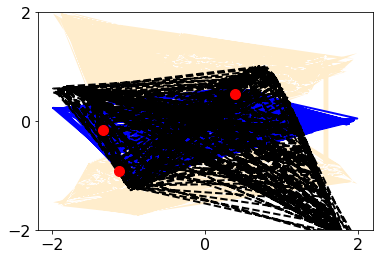

In [13]:
plot_functions(target_x, target_y, context_x, context_y, pred_y, var)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

target = target_y[0,:,0]
pred = pred_y[0,:,0]
rmse = np.sqrt(mean_squared_error(target, pred))
mae = mean_absolute_error(target, pred)
r2 = r2_score(target, pred)
print("RMSE: {:.5f}, MAP:{:.5f}, R^2: {:.5f}".format(rmse, mae, r2))

RMSE: 0.69961, MAP:0.46366, R^2: 0.27810
